In [1]:
from google.colab import drive; drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks' #Run in Google Colab to take advantage of GPU

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


Install packages and Load Packages

In [174]:
!pip install transformers
!pip install sec-api


Load Packages

In [175]:
import nltk
from bs4 import BeautifulSoup
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import requests
from tqdm import tqdm
import re
from sec_api import QueryApi
from sec_api import ExtractorApi
from datetime import datetime
import os
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [154]:
isRepresentation = True # Change to False to rerun the whole process 

Get 10Ks

In [176]:
cik_lookup = {'FL': '0000850209',
 'AAPL': None,
 'TMUS': None,
 'HON': '0000773840',
 'IP': '0000051434',
 'INTC': None,
 'MDT': None,
 'GE': '0000040545',
 'PEP': '0000077476',
 'AMD': None,
 'BAC': None,
 'EMR': '0000032604',
 'TWTR': None,
 'MET': None,
 'T': None,
 'MCHP': None,
 'TJX': None,
 'MSFT': None,
 'UPS': None,
 'ED': '0001047862',
 'JNJ': '0000200406',
 'PHM': None,
 'CNP': '0001130310',
 'AMZN': '0001018724',
 'LLY': '0000059478',
 'MRK': '0000310158',
 'COF': None,
 'AXP': '0000004962',
 'CTSH': None,
 'MMM': None,
 'WFC': '0000072971',
 'C': None,
 'UAL': None,
 'NCLH': None,
 'ETN': '0001551182',
 'JCI': None,
 'MRO': '0000101778',
 'AAL': None,
 'WRK': None,
 'MU': None,
 'BMY': '0000014272',
 'PPL': None,
 'DTE': '0000936340',
 'TXN': '0000097476',
 'WMT': '0000104169',
 'VZ': None,
 'ADBE': None,
 'PSX': None,
 'MA': None,
 'KEY': None,
 'RCL': None,
 'CAT': '0000018230',
 'MDLZ': None,
 'DIS': '0001001039',
 'FISV': None,
 'WU': None,
 'XOM': '0000034088',
 'PLD': None,
 'DHI': None,
 'HAL': None,
 'NUE': None,
 'FRT': '0000034903',
 'CRM': None,
 'GPN': None,
 'GLW': None,
 'AEP': '0000004904',
 'CSX': None,
 'PNR': '0000077360',
 'LKQ': None,
 'AFL': None,
 'PBCT': None,
 'USB': None,
 'KO': '0000021344',
 'IBM': '0000051143',
 'ISRG': None,
 'HD': None,
 'ABBV': None,
 'CAH': None,
 'HWM': None,
 'WDC': None,
 'IPG': None,
 'CVX': '0000093410',
 'MPC': None,
 'APA': None,
 'BK': '0001390777',
 'XEL': None,
 'FIS': None,
 'SBUX': None,
 'GM': None,
 'EXC': None,
 'KIM': None,
 'WY': '0000106535',
 'HBAN': None,
 'PFE': '0000078003',
 'NKE': None,
 'SPG': None,
 'MCD': '0000063908',
 'NRG': None,
 'GPS': None,
 'MGM': None,
 'PENN': None,
 'NEE': None,
 'ATVI': None,
 'GIS': None,
 'CNC': None,
 'DVN': None,
 'UTX': '0000101829',
 'V': None,
 'CSCO': None,
 'WYNN': None,
 'SCHW': None,
 'NVDA': None,
 'LYB': None,
 'EOG': None,
 'TSN': None,
 'SYF': None,
 'WBA': None,
 'OXY': None,
 'D': None,
 'ORCL': None,
 'FAST': None,
 'COP': None,
 'ABT': None,
 'SLB': None,
 'LVS': None,
 'UNH': None,
 'WMB': None,
 'SO': None,
 'ADI': None,
 'TPR': None,
 'CVS': None,
 'QCOM': None,
 'ROL': None,
 'PGR': None,
 'AES': None,
 'LOW': None,
 'DOW': None,
 'IVZ': None,
 'AMAT': None,
 'JPM': None,
 'SYY': '0000096021',
 'PYPL': None,
 'FCX': None,
 'BBY': None,
 'HPE': None,
 'PM': None,
 'VFC': None,
 'NEM': None,
 'EA': None,
 'HST': None,
 'TGT': None,
 'LUV': None}

Get 10K Urls from EDGAR database using sec-api

In [177]:
def get_sec_urls(secTicker, doc_type='10-K', startDate='2019-01-01', endDate='2020-12-31'):
    entries = []
    queryApi = QueryApi(api_key="adbd60e46a32fc6a45ab4686907b7ba96b2e820b2063cea584ea335da12ae9cf")
    query = {
        "query": {"query_string": {
            "query": "ticker: " + secTicker + " AND filedAt:{" + startDate + " TO " + endDate + "} AND formType:\"10-K\""
        }},
        "from": "0",
        "size": "10",
        "sort": [{"filedAt": {"order": "desc"}}]
    }
    filings = queryApi.get_filings(query)
    for record in filings['filings']:
        if doc_type in record['documentFormatFiles'][0]['type']:
            href = record['documentFormatFiles'][0]['documentUrl']
            doc_type =  record['documentFormatFiles'][0]['type']
            date = pd.to_datetime(record['filedAt']).strftime('%Y-%m-%d')
            entries.append((href, doc_type, date))
    return entries

In [178]:
if not isPresentation:
    for ticker, cik in cik_lookup.items():
        for tikcer in tqdm(ticker, desc='Getting {} Fillings'.format(ticker)):
            sec_data[ticker] = get_sec_urls(ticker, doc_type='10-K', startDate='2015-01-01', endDate='2021-12-31')

Get 10K Text Data (It's going to take a long time to download the 10k files, so you can extract the files in 10kfiles.zip and put it under the subfolder 'team project' in the working directory)

In [179]:
def download_10K(index_url, file_date, secTicker):
    extractorApi = ExtractorApi("adbd60e46a32fc6a45ab4686907b7ba96b2e820b2063cea584ea335da12ae9cf")
    section_text = extractorApi.get_section(index_url, "1A", "text")
    with open('{}_{}_10K.txt'.format(secTicker, file_date),'w') as f:
        f.write(section_text)
    return section_text

In [180]:
tenK_fillings_by_ticker = {}
if not isPresentation:
    for ticker, data in sec_data.items():
        tenK_fillings_by_ticker[ticker] = {}
        for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
            if (file_type == '10-K'):
                tenK_fillings_by_ticker[ticker][file_date] = download_10K(index_url,file_date,ticker)
else:
    for file in os.listdir(r'./team project'):
        if '10K' in file:
            ticker, date, base = file.split('_')
            if ticker not in tenK_fillings_by_ticker:
                tenK_fillings_by_ticker[ticker] = dict() 
            with open(r'./team project/{}'.format(file),'r') as f:
                tenK_fillings_by_ticker[ticker][date] = f.read()
    

In [181]:
ten_ks_by_ticker = {}

for ticker, filling_documents in tenK_fillings_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date in sorted(filling_documents.keys()):
        ten_ks_by_ticker[ticker].append({
            'file': filling_documents[file_date],
            'file_date': file_date})

Clean up steps

In [185]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.replace('\n','')
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    return text

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])

Cleaning WRK 10-Ks: 100%|██████████| 7/7 [00:00<00:00, 566.7910-K/s]


Lemmatize

In [182]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    lemmed = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]
    return lemmed

In [186]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))



Lemmatize WRK 10-Ks: 100%|██████████| 7/7 [00:00<00:00, 26.1110-K/s]


Remove Stopwords

In [187]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for WRK 10-Ks: 100%|██████████| 7/7 [00:00<00:00, 62.8710-K/s]

Stop Words Removed


Analysis on 10Ks

Loughran McDonald Sentiment Word Lists (English sentiment lexicon created for use with financial documents)

*   Negative
*   Positive
*   Uncertainty
*   Litigious
*   Constraining
*   Superfluous
*   Modal














In [188]:

sentiments = ['negative', 'positive']#, 'uncertainty', 'litigious', 'constraining', 'interesting']
# sentimenets = ['negative', 'positive']
sentiment_df = pd.read_csv(r'./team project/loughran_mcdonald_master_dic_2016.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] 

sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()


,negative,positive,word
9,True,False,abandon
12,True,False,abandonment
13,True,False,abandonments
51,True,False,abdicate
54,True,False,abdication


Bag of Words

In [189]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs, len_doc):
    cnt_vec = CountVectorizer(vocabulary=sentiment_words)
    bag_of_words = cnt_vec.fit_transform([docs]).toarray() 
    score = sum(bag_of_words[0])/len_doc
    return score

In [190]:
sentiment_bow_ten_ks = {}
sentiment_score_bow = list()
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in ten_ks:
        len_doc = len(ten_k['file_lemma'])
        ten_k['pos_score_bow'] = get_bag_of_words(sentiment_df[sentiment_df['positive']]['word'], ' '.join(ten_k['file_lemma']),len_doc)
        ten_k['neg_score_bow'] = get_bag_of_words(sentiment_df[sentiment_df['negative']]['word'], ' '.join(ten_k['file_lemma']),len_doc)
        ten_k['sentiment_score_bow'] = (ten_k['pos_score_bow']*len_doc - ten_k['neg_score_bow']*len_doc)/len_doc
    
        sentiment_score_bow.append([ticker,ten_k['file_date'],ten_k['pos_score_bow'],ten_k['neg_score_bow'],ten_k['sentiment_score_bow']])

sentiment_df_bow = pd.DataFrame(sentiment_score_bow,columns=['ticker','asofdate','pos_score','neg_score','sentiment_score'])
sentiment_df_bow['asofdate'] = pd.to_datetime(sentiment_df_bow['asofdate'])

In [191]:
sentiment_df_bow.head()


,ticker,asofdate,pos_score,neg_score,sentiment_score
0,NUE,2015-02-27,0.011794,0.079115,-0.067322
1,NUE,2016-02-26,0.010732,0.077073,-0.066341
2,NUE,2017-02-28,0.010955,0.077726,-0.066771
3,NUE,2018-02-28,0.010995,0.079058,-0.068063
4,NUE,2019-02-28,0.010526,0.074211,-0.063684


finBERT: BERT is a transformed-based word representation, which takes into account context from both directions and is able to capture context from a broader range and finBERT is BERT pre-trained on financial text. https://github.com/ProsusAI/finBERT.

The largest token size for a finBERT is 512, so I use the pre-trained finBERT to predict the sentiment on every 512 consecutive tokens and define neg_score as the number of sections predicted to be negative divided by total number of sections. A section is every 512 tokens. I also define pos_score the same way. The sentiment_score is defined as the difference between positive sections and negative sections divided by total number of sections, it's a metric used to measure overall sentiment.

The pre-trained finBERT should be placed under folder 'finbertProsus'

In [194]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('finbertProsus/pytorch_model.bin',config='finbertProsus/config.json',num_labels=3).to(device)

label_list=['positive','negative','neutral']
def compute_sentiment_score(file):
    pos = 0 
    neg = 0 
    if len(file)<512:
        inputs = tokenizer(file, return_tensors="pt")
        inputs.to(device)
        outputs = model(**inputs)
        s = torch.argmax(outputs[0])
        if s==0: 
            pos+=1
        elif s==1:
            neg+=1
        i = 1
    else:
        for i in range(int(len(file)/512)):
            inputs = tokenizer(file[512*i:512*(i+1)], return_tensors="pt")
            inputs.to(device)
            outputs = model(**inputs)
            s = torch.argmax(outputs[0])
            if s==0: 
                pos+=1
            elif s==1:
                neg+=1
    return pos/i, neg/i, (pos-neg)/i, i
    

In [ ]:
import csv
isPresentation=True
if not isPresentation:
    with open('sentiment_scores.csv','w') as f:
        writer = csv.writer(f)    
        for ticker, ten_ks in ten_ks_by_ticker.items():
            for ten_k in tqdm(ten_ks, desc='Computing Sentiment Score for {}'.format(ticker), unit='10-K'):
                try:
                    ten_k['pos_score'],ten_k['neg_score'],ten_k['sentiment_score'],ten_k['sections'] = compute_sentiment_score(ten_k['file_clean'])
                    # print(ticker,ten_k['file_date'],ten_k['pos_score'],ten_k['neg_score'],ten_k['sentiment_score'],ten_k['sections'])
                    writer.writerow([ticker,ten_k['file_date'],ten_k['pos_score'],ten_k['neg_score'],ten_k['sentiment_score'],ten_k['sections']])
                except:
                    print('error',ticker)
                    continue


Computing Sentiment Score for MSFT: 100%|██████████| 10/10 [00:16<00:00,  1.66s/10-K]

Computing Sentiment Score for UAL: 100%|██████████| 9/9 [00:17<00:00,  1.95s/10-K]

Computing Sentiment Score for WFC: 100%|██████████| 10/10 [00:00<00:00, 49.4410-K/s]

Computing Sentiment Score for C: 100%|██████████| 6/6 [00:00<00:00, 63.0410-K/s]

Computing Sentiment Score for KO: 100%|██████████| 10/10 [00:20<00:00,  2.04s/10-K]

Computing Sentiment Score for DE: 100%|██████████| 4/4 [00:09<00:00,  2.27s/10-K]

Computing Sentiment Score for CAT: 100%|██████████| 10/10 [00:26<00:00,  2.67s/10-K]

Computing Sentiment Score for DIS: 100%|██████████| 10/10 [00:16<00:00,  1.63s/10-K]

Computing Sentiment Score for EMR: 100%|██████████| 10/10 [00:06<00:00,  1.5310-K/s]

Computing Sentiment Score for DTE: 100%|██████████| 10/10 [00:13<00:00,  1.31s/10-K]

Computing Sentiment Score for ED: 100%|██████████| 10/10 [00:07<00:00,  1.3210-K/s]

Computing Sentiment Score for ETN: 100%|██████████| 10/10 [00:0

error JNJ
error JNJ



Computing Sentiment Score for JNJ: 100%|██████████| 10/10 [00:05<00:00,  1.8610-K/s]

Computing Sentiment Score for IBM: 100%|██████████| 10/10 [00:01<00:00,  5.5310-K/s]

Computing Sentiment Score for LLY: 100%|██████████| 10/10 [00:11<00:00,  1.12s/10-K]

Computing Sentiment Score for MCD: 100%|██████████| 10/10 [00:12<00:00,  1.30s/10-K]

Computing Sentiment Score for PEP: 100%|██████████| 10/10 [00:33<00:00,  3.39s/10-K]

Computing Sentiment Score for MRK: 100%|██████████| 10/10 [00:28<00:00,  2.86s/10-K]

Computing Sentiment Score for MRO: 100%|██████████| 9/9 [00:19<00:00,  2.15s/10-K]

Computing Sentiment Score for TXN: 100%|██████████| 10/10 [00:11<00:00,  1.13s/10-K]

Computing Sentiment Score for PNR: 100%|██████████| 7/7 [00:23<00:00,  3.43s/10-K]

Computing Sentiment Score for AAPL: 100%|██████████| 10/10 [00:27<00:00,  2.78s/10-K]

Computing Sentiment Score for UTX: 100%|██████████| 6/6 [00:03<00:00,  1.9710-K/s]

Computing Sentiment Score for WMT: 100%|██████████| 10/10 

error WY
error WY



Computing Sentiment Score for IVZ: 100%|██████████| 6/6 [00:24<00:00,  4.09s/10-K]

Computing Sentiment Score for LKQ: 100%|██████████| 6/6 [00:25<00:00,  4.20s/10-K]

Computing Sentiment Score for MMM: 100%|██████████| 6/6 [00:03<00:00,  1.5510-K/s]

Computing Sentiment Score for MOS: 100%|██████████| 2/2 [00:09<00:00,  4.84s/10-K]

Computing Sentiment Score for PHM: 100%|██████████| 6/6 [00:09<00:00,  1.61s/10-K]

Computing Sentiment Score for VFC: 100%|██████████| 6/6 [00:15<00:00,  2.50s/10-K]

Computing Sentiment Score for GIS: 100%|██████████| 5/5 [00:04<00:00,  1.1410-K/s]

Computing Sentiment Score for NI: 100%|██████████| 3/3 [00:00<00:00,  5.4410-K/s]

Computing Sentiment Score for DD: 100%|██████████| 3/3 [00:07<00:00,  2.44s/10-K]

Computing Sentiment Score for TGT: 100%|██████████| 6/6 [00:08<00:00,  1.43s/10-K]

Computing Sentiment Score for XEL: 100%|██████████| 6/6 [00:13<00:00,  2.17s/10-K]

Computing Sentiment Score for PSX: 100%|██████████| 6/6 [00:11<00:00,  1.88s/

Evaluate Alpha Factors

Get adjusted closing prices for stocks from yahoo finance

In [195]:
!pip install yfinance
import yfinance as yf
import pandas as pd
from datetime import datetime
isRepresentation = True

if not isRepresentation:
    tickers_data = ['MSFT','UAL','KO','DE','CAT','DIS','EMR','DTE','ED','ETN','GE','IP','JNJ','IBM','LLY','MCD','PEP','MRK','MRO','TXN','PNR','AAPL','UTX','WMT','XOM','AAL','F','AMD','NVDA','T','PFE','BAC','INTC','NCLH','FL','AMZN','CNP','CVX','HON','FRT','AEP','AXP','WRK','LOW','UPS','NUE','NFLX','BAX','WDC','EOG','ADBE','JCI','COF','CTVA','PLD','AFL','IVZ','LKQ','MMM','MOS','PHM','VFC','GIS','NI','DD','TGT','XEL','PSX','PENN','ADI','TPR','GLW','DHI','GPN','STT','SYY','HWM','NWL','SCHW','BBY','FISV','HD','PBCT','NLOK','UNH','FITB','MCHP','D','MET','FAST','TMUS','RTX','WYNN','CNC','KIM','AES','CFG','NKE','O','MPC','SYF','MDLZ','CVS','AIG','MA','DOW','EXC','COP','FIS','ABT','CL','PM','AMCR','BKR','GILD','PPL','CRM','NEM','HBI','MDT','RCL','HST','TJX','SBUX','RF','APA','ORCL','DVN','KEY','QCOM','AMAT','NEE','ABBV','BSX','SO','SLB','WBA','MGM','ATVI','MS','KHC','HBAN','WMB','LVS','WU','KR','V','OXY','JPM','BA','HPQ','HPE','LUV','PYPL','FCX','GPS','CSX','MU','GM','VIAC','KMI','BMY','MRNA','FB','CSCO','VZ','DAL','CMCSA','TWTR','TSN','LYB','PGR','NRG','FOXA','ROL','SPG','IPG','EA','CTSH','ISRG','DUK']
    data = yf.download(tickers=tickers_data)
    data['Adj Close'].to_csv('adj_close.csv')
else:
    df = pd.read_csv('adj_close.csv',parse_dates=['Date'])
    prices_df = df[df['Date']>=datetime(2015,1,1)]
    # first_dates = df['Date'].groupby([pd.DatetimeIndex(df['Date']).year]).min('Date').values
    # first_dates_prices = df[(df['Date'].isin(first_dates)) & (df['Date']>datetime(2014,1,1))].reset_index()
    # first_dates_prices['Date'] = pd.DatetimeIndex(first_dates_prices['Date']).year
    # first_dates_prices['Date'] = pd.to_datetime(first_dates_prices['Date'], format='%Y')
    # first_dates_prices = first_dates_prices.set_index('Date')
    # first_dates_prices = first_dates_prices.drop(columns=['index'])

In [196]:
prices_df.head(10)

,Date,AAL,AAPL,ABBV,ABT,ADBE,ADI,AEP,AES,AFL,AIG,AMAT,AMCR,AMD,AMZN,APA,ATVI,AXP,BA,BAC,BAX,BBY,BKR,BMY,BSX,CAT,CFG,CL,CMCSA,CNC,CNP,COF,COP,CRM,CSCO,CSX,CTSH,CTVA,CVS,CVX,...,PSX,PYPL,QCOM,RCL,RF,ROL,RTX,SBUX,SCHW,SLB,SO,SPG,STT,SYF,SYY,T,TGT,TJX,TMUS,TPR,TSN,TWTR,TXN,UAL,UNH,UPS,UTX,V,VFC,VIAC,VZ,WBA,WDC,WMB,WMT,WRK,WU,WYNN,XEL,XOM
13343,2015-01-02,51.079922,24.746002,48.810207,39.254292,72.339996,47.608585,47.961666,10.705758,25.818510,47.397808,22.566765,8.467041,2.67,308.519989,55.504475,19.168921,83.556068,113.657196,15.724234,36.403481,31.538467,32.999977,49.214886,13.22,74.674454,20.082748,58.726612,25.138788,26.110001,17.886282,72.656906,56.079224,59.240002,22.310589,10.646878,49.817860,NaN,79.819778,82.508774,...,56.090137,NaN,59.418434,73.958031,8.509998,8.761793,61.067463,35.957390,27.936090,68.823135,35.873730,136.030136,66.425529,25.843908,33.431488,22.462130,61.676888,30.976856,27.299999,30.127640,35.275963,36.560001,44.549072,66.339996,90.382690,89.539330,NaN,63.217800,58.933708,48.823166,34.300694,62.849709,92.755753,29.578081,73.684166,NaN,14.022661,129.637009,29.311962,66.757805
13344,2015-01-05,51.051487,24.048859,47.891632,39.263031,71.980003,46.742817,47.255764,10.401000,25.142187,46.460159,21.843464,8.467041,2.66,302.190002,52.095768,18.902290,81.346344,112.870064,15.267437,35.499710,30.725397,32.406605,48.445774,13.81,70.732681,19.612312,58.292801,24.626116,26.040001,17.318588,70.983406,53.410328,58.169998,21.866154,10.358804,49.505737,NaN,79.030800,79.210777,...,52.699432,NaN,59.138474,72.852448,8.218504,8.753694,60.048241,35.268631,27.002424,66.959351,35.721142,136.587952,65.323395,25.642271,33.104290,22.249914,60.571571,30.630436,26.930000,29.659279,34.463612,36.380001,43.857689,66.150002,88.893959,87.746567,NaN,61.822338,58.438335,48.350880,34.015839,61.609261,91.529388,28.407257,73.469696,NaN,13.889710,127.430603,28.979235,64.931190
13345,2015-01-06,50.255577,24.051125,47.654572,38.817162,70.529999,45.645607,47.514599,10.166563,24.918159,45.801270,21.020721,8.467041,2.63,295.290009,51.530548,18.549953,79.612732,111.540642,14.810644,35.311008,30.448975,32.306721,48.363068,13.70,70.277527,19.393314,57.680347,24.304865,26.125000,16.932552,69.662209,51.205257,57.200001,21.858074,9.945992,48.219387,NaN,79.089554,79.174118,...,51.225220,NaN,58.298523,73.066429,7.943202,8.615988,59.198910,34.981632,26.013287,65.649902,36.149849,140.389786,63.458214,25.291605,32.928120,22.283068,60.563381,30.480030,26.870001,29.312050,34.666695,38.759998,43.132969,64.580002,88.714554,87.170647,NaN,61.423973,58.094776,47.397404,34.359138,61.766399,89.488319,28.021339,74.035858,NaN,13.866244,124.712387,29.133432,64.586006
13346,2015-01-07,50.227161,24.388376,49.580616,39.131893,71.110001,46.125637,48.189114,10.182193,25.074564,46.020901,21.219627,8.104171,2.58,298.420013,50.956635,18.150005,81.351479,113.272377,14.880918,35.479843,31.327074,33.176228,48.991608,14.03,71.366615,19.466314,58.139687,24.282860,26.267500,17.152063,70.454926,51.546989,56.930000,22.060089,10.076664,49.798950,NaN,80.516411,79.108162,...,51.450218,NaN,58.978497,74.172012,7.991788,8.804995,59.841236,35.842598,26.521723,65.641853,36.549507,142.973328,64.051697,25.598436,33.892891,22.309973,62.855907,31.104486,28.250000,30.216454,35.090542,37.279999,43.907665,65.529999,89.620399,87.981834,NaN,62.246952,58.837837,47.326126,34.137421,63.345901,90.832237,27.870895,76.000198,NaN,13.733292,128.374939,29.384996,65.240417
13347,2015-01-08,50.843037,25.325434,50.099171,39.936218,72.919998,46.939980,48.604813,10.338478,25.319729,45.818169,21.897713,8.104171,2.61,300.459991,52.930553,18.330936,82.504616,115.275269,15.188375,36.398495,31.798651,33.505238,50.215557,14.59,72.098076,19.612312,58.930759,24.810936,26.672501,17.560808,71.141945,52.832619,58.590000,22.229784,10.237039,50.962341,NaN,82.228630,80.918419,...,53.452057,NaN,59.602409,75.348923,8.113243,9.002101,60.860447,36.420990,27.215038,66.437172,36.578568,142.767792,65.408180,26.282228,34.505318,22.531925

In [197]:
!pip install alphalens
import alphalens as al


Load saved sentiment scores predicted using finBERT

In [198]:
sentiment_df_finbert = pd.read_csv('sentiment_scores.csv',parse_dates=['asofdate'])
sentiment_df_finbert = sentiment_df_finbert[((sentiment_df_finbert['asofdate']>=datetime(2015,1,1)) & (sentiment_df_finbert['runs']>1))]

In [68]:
sentiment_df_finbert.head()

,ticker,asofdate,pos_score,neg_score,sentiment_score,runs
0,AAL,2015-02-25,0.046392,0.309278,-0.262887,194
1,AAL,2016-02-24,0.063158,0.300000,-0.236842,190
2,AAL,2017-02-22,0.100592,0.254438,-0.153846,169
3,AAL,2018-02-21,0.102703,0.291892,-0.189189,185
4,AAL,2019-02-25,0.109005,0.255924,-0.146919,211


In [199]:
prices_df = prices_df.melt('Date',var_name='ticker',value_name='adj_close')

In [200]:
def merge_return_factor(prices_df, sentiment_df):
    merged = pd.merge(prices_df, sentiment_df,left_on=['Date','ticker'],right_on=['asofdate','ticker'],how='left')
    for tick in set(merged['ticker']):
        merged.loc[merged['ticker']==tick,'neg_score_fill'] = merged.loc[merged['ticker']==tick,'neg_score'].fillna(method='ffill')
        merged.loc[merged['ticker']==tick,'pos_score_fill'] = merged.loc[merged['ticker']==tick,'pos_score'].fillna(method='ffill')
        merged.loc[merged['ticker']==tick,'sentiment_score_fill'] = merged.loc[merged['ticker']==tick,'sentiment_score'].fillna(method='ffill')
    return merged

Bag of Words Sentiment Factors Analysis

In [201]:
factor_data_bow = dict()
for sentiment in ['neg_score_fill','pos_score_fill','sentiment_score_fill']:
    merged = merge_return_factor(prices_df, sentiment_df_bow)
    merged = merged.loc[merged['Date']>datetime(2016,1,1),['Date','ticker','adj_close','neg_score_fill','sentiment_score_fill','pos_score_fill']]
    merged = merged.dropna(axis=0)
    factors = merged[['Date','ticker',sentiment]].reset_index().pivot(index='Date', columns='ticker', values=sentiment)
    data = al.utils.get_clean_factor_and_forward_returns(factors.stack(),merged.pivot(index='Date',columns='ticker', values='adj_close') , quantiles=5, bins=None, periods=[1])
    factor_data_bow[sentiment] = data

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [132]:
factor_data_bow['pos_score_fill'] # first quantile represents the ticker with least positive sentiment

1D    factor  factor_quantile
date       asset                                     
2016-01-04 AAL   -0.009533  0.013818                2
           AAPL  -0.025059  0.012536                1
           ABBV  -0.004166  0.023290                5
           ABT   -0.000233  0.025011                5
           ADBE   0.004023  0.018108                3
...                    ...       ...              ...
2021-12-06 WRK   -0.006376  0.015527                3
           WU    -0.029132  0.012984                2
           WYNN   0.018019  0.013043                2
           XEL    0.013194  0.012668                2
           XOM    0.011205  0.029683                5

[240395 rows x 3 columns]

In [133]:
factor_data_bow['neg_score_fill'] #first quantile represents the ticker with least negative sentiment

1D    factor  factor_quantile
date       asset                                     
2016-01-04 AAL   -0.009533  0.058589                1
           AAPL  -0.025059  0.068023                2
           ABBV  -0.004166  0.066334                2
           ABT   -0.000233  0.086675                5
           ADBE   0.004023  0.086322                5
...                    ...       ...              ...
2021-12-06 WRK   -0.006376  0.075695                3
           WU    -0.029132  0.072190                3
           WYNN   0.018019  0.075596                3
           XEL    0.013194  0.062326                1
           XOM    0.011205  0.061412                1

[240395 rows x 3 columns]

In [134]:
factor_data_bow['sentiment_score_fill'] # first quantile represents the ticker with most negative sentiment

1D    factor  factor_quantile
date       asset                                     
2016-01-04 AAL   -0.009533 -0.044771                5
           AAPL  -0.025059 -0.055487                3
           ABBV  -0.004166 -0.043044                5
           ABT   -0.000233 -0.061665                2
           ADBE   0.004023 -0.068214                1
...                    ...       ...              ...
2021-12-06 WRK   -0.006376 -0.060168                3
           WU    -0.029132 -0.059205                3
           WYNN   0.018019 -0.062553                2
           XEL    0.013194 -0.049658                4
           XOM    0.011205 -0.031730                5

[240395 rows x 3 columns]

In [135]:
unixt_factor_data_bow = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data_bow.items()}

Factor Returns for Bag of Words Sentiment scores

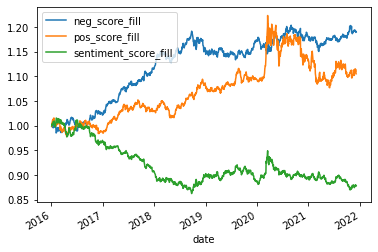

In [202]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data_bow.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

Basis Points Per Day per Quantile for Bag of Words Sentiment Scores (seems to be monotonic in quantiles)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa04a2e4bd0>,
      dtype=object)

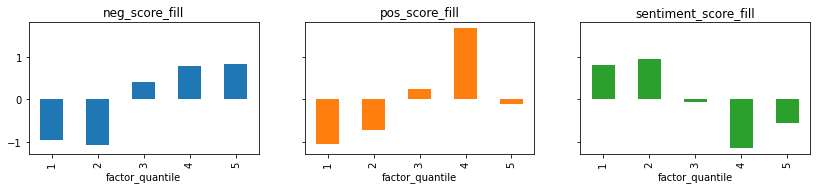

In [203]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data_bow.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

Sharpe Ratio for Bag of Words sentiment scores

In [204]:
import numpy as np
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

neg_score_fill          0.84
pos_score_fill          0.34
sentiment_score_fill   -0.56
dtype: float64

finBERT Sentiment Factors Analysis

In [205]:
factor_data = dict()
for sentiment in ['neg_score_fill','sentiment_score_fill','pos_score_fill']:
    merged = merge_return_factor(prices_df, sentiment_df_finbert)
    merged = merged.loc[merged['Date']>datetime(2016,1,1),:]
    factors = merged[['Date','ticker',sentiment]].reset_index().pivot(index='Date', columns='ticker', values=sentiment)
    
    # sentiment_agg = sentiment_scores_df.groupby(['ticker', 'date']).max('asofdate').reset_index().pivot(index='date', columns='ticker', values=sentiment).dropna(axis=1)
    data = al.utils.get_clean_factor_and_forward_returns(factors.stack(),merged.pivot(index='Date',columns='ticker', values='adj_close') , quantiles=5, bins=None, periods=[1])
    factor_data[sentiment] = data

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [140]:
factor_data['neg_score_fill'] # #first quantile represents the ticker with least negative sentiment

1D    factor  factor_quantile
date       asset                                     
2016-01-04 AAL   -0.009533  0.309278                1
           AAPL  -0.025059  0.407767                3
           ABBV  -0.004166  0.405941                3
           ABT   -0.000233  0.458333                4
           ADBE   0.004023  0.581967                5
...                    ...       ...              ...
2021-12-06 WRK   -0.006376  0.459184                4
           WU    -0.029132  0.352679                2
           WYNN   0.018019  0.341935                2
           XEL    0.013194  0.358025                2
           XOM    0.011205  0.325000                1

[237036 rows x 3 columns]

In [141]:
factor_data['sentiment_score_fill'] # first quantile represents the ticker with most negative sentiment

1D    factor  factor_quantile
date       asset                                     
2016-01-04 AAL   -0.009533 -0.262887                5
           AAPL  -0.025059 -0.368932                3
           ABBV  -0.004166 -0.396040                2
           ABT   -0.000233 -0.458333                1
           ADBE   0.004023 -0.557377                1
...                    ...       ...              ...
2021-12-06 WRK   -0.006376 -0.418367                2
           WU    -0.029132 -0.316964                4
           WYNN   0.018019 -0.303226                4
           XEL    0.013194 -0.345679                4
           XOM    0.011205 -0.175000                5

[237036 rows x 3 columns]

In [142]:
factor_data['pos_score_fill'] # first quantile represents the ticker with least positive sentiment

1D    factor  factor_quantile
date       asset                                     
2016-01-04 AAL   -0.009533  0.046392                4
           AAPL  -0.025059  0.038835                3
           ABBV  -0.004166  0.009901                1
           ABT   -0.000233  0.000000                1
           ADBE   0.004023  0.024590                2
...                    ...       ...              ...
2021-12-06 WRK   -0.006376  0.040816                4
           WU    -0.029132  0.035714                3
           WYNN   0.018019  0.038710                3
           XEL    0.013194  0.012346                1
           XOM    0.011205  0.150000                5

[237036 rows x 3 columns]

In [148]:
unixt_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

Factor Returns for finBERT Sentiment scores

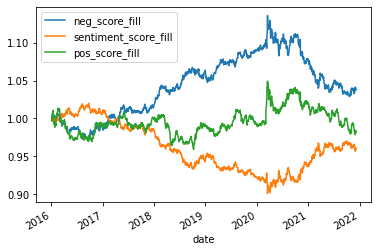

In [146]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

(1 + ls_factor_returns).cumprod().plot()

Basis Points Per Day per Quantile for finBERT Sentiment Scores (seems to be LESS monotonic in quantiles than bag of words)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa045f8d350>,
      dtype=object)

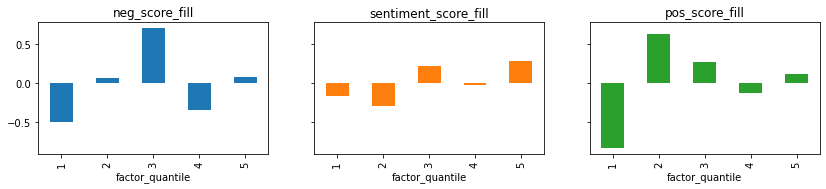

In [149]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unixt_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False)

Sharpe Ratio for finBERT sentiment scores 

In [150]:
import numpy as np
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

neg_score_fill          0.21
sentiment_score_fill   -0.23
pos_score_fill         -0.08
dtype: float64